# Mind Your Accent: An Empirical Study on Differences in Performance of Various Machine Learning Models for Accent Classification

This notebook contains all the code we wrote for our project including data colleciton, data processing, model building and training, as well as model evaluation.

As an initial step to our project, we scraped audio data from VoxForge Speech Corpus and saved it locally and obtained the accent classes from the Readme's extracted from the .tgz files.

In [ ]:
import os
import requests
import tarfile
from bs4 import BeautifulSoup

# URL for VoxForge 16kHz audio files
BASE_URL = 'https://repository.voxforge1.org/downloads/SpeechCorpus/Trunk/Audio/Main/16kHz_16bit/'
DOWNLOAD_DIR = 'voxforge_data'

#get all .tgz file links from the URL
def get_tgz_links(url):

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tgz_links = [link.get('href') for link in soup.find_all('a') if link.get('href').endswith('.tgz')]
    return tgz_links

#Download and extract a .tgz file into the specified directory
def download_and_extract_tgz(tgz_url, download_path):

    filename = tgz_url.split('/')[-1]
    file_path = os.path.join(download_path, filename)

    print(f'Downloading {filename}...')
    response = requests.get(tgz_url, stream=True)
    with open(file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

    print(f'Extracting {filename}...')
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=download_path)

    os.remove(file_path)
#parse README file and extract key value metadata pairs
def parse_readme(readme_path):
    metadata = {}
    with open(readme_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            if ':' in line:
                key, value = line.strip().split(':', 1)
                metadata[key.strip()] = value.strip()
    return metadata

#Traverse all subdirectories and get metadata from README files
def collect_metadata(data_dir):
    metadata_list = []
    for root, dirs, files in os.walk(data_dir):
        if 'README' in files:
            readme_path = os.path.join(root, 'README')
            metadata = parse_readme(readme_path)
            metadata['path'] = root
            metadata_list.append(metadata)
    return metadata_list

def main():
    if not os.path.exists(DOWNLOAD_DIR):
        os.makedirs(DOWNLOAD_DIR)

    tgz_links = get_tgz_links(BASE_URL)
    for link in tgz_links:
        full_url = BASE_URL + link
        download_and_extract_tgz(full_url, DOWNLOAD_DIR)

    print('complete.')

    print('parsing metadata from README files')
    metadata_entries = collect_metadata(DOWNLOAD_DIR)
    for entry in metadata_entries:
        print(entry)

if __name__ == '__main__':
    main()

We further subsetted our scraped data to only include 200 samples of each of our 3 target classes: American English, Canadian English, and European English. We did this to reduce the complexity of our problem since we would be loooking at a number of model architectures.

In [ ]:
import os
import shutil
from collections import defaultdict
from random import shuffle

SOURCE_DIR = 'voxforge_data'
DEST_DIR = 'balanced_voxforge_subset'
SAMPLES_PER_ACCENT = 200

TARGET_ACCENTS = {
    'American English',
    'European English',
    'Canadian English'
}
# parse README to extract pronunciation dialect
def parse_readme(readme_path):

    dialect = None
    with open(readme_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            if 'Pronunciation dialect' in line:
                _, value = line.strip().split(':', 1)
                dialect = value.strip()
                break
    return dialect
# Traverse voxforge data and group paths by selected accent classes
def collect_accent_samples(data_dir):

    accent_dict = defaultdict(list)

    for root, dirs, files in os.walk(data_dir):
        if 'etc' in dirs:
            readme_path = os.path.join(root, 'etc', 'README')
            if os.path.exists(readme_path):
                accent = parse_readme(readme_path)
                if accent in TARGET_ACCENTS:
                    accent_dict[accent].append(root)

    return accent_dict
 #Copy balanced samples of the selected accents into a new directory
def create_balanced_subset(accent_dict, max_per_class, dest_dir):

    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for accent, paths in accent_dict.items():
        shuffle(paths)
        selected = paths[:max_per_class]
        accent_sanitized = accent.replace(" ", "_")

        for i, sample_path in enumerate(selected):
            new_dir_name = f"{accent_sanitized}_{i}"
            dest_path = os.path.join(dest_dir, new_dir_name)
            shutil.copytree(sample_path, dest_path)

        print(f"Copied {len(selected)} samples for accent: {accent}")

def main():
    accent_samples = collect_accent_samples(SOURCE_DIR)
    print("Available samples per target accent:")
    for accent in TARGET_ACCENTS:
        count = len(accent_samples.get(accent, []))
        print(f"{accent}: {count}")

    create_balanced_subset(accent_samples, SAMPLES_PER_ACCENT, DEST_DIR)

if __name__ == '__main__':
    main()

## Data and Models

The rest of this notebook contains code for data preprocessing as well as model building, training, and evaluation. To run this code, you must have the following folder containing the relevant data.

```
"Machine Learning/Final Project/"
```



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# importing relevant modules

import os
import librosa
import numpy as np
from tqdm import tqdm
import librosa.display
from pathlib import Path
import matplotlib.pyplot as plt

# for less complex models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# for neurla nets
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Sequential, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical

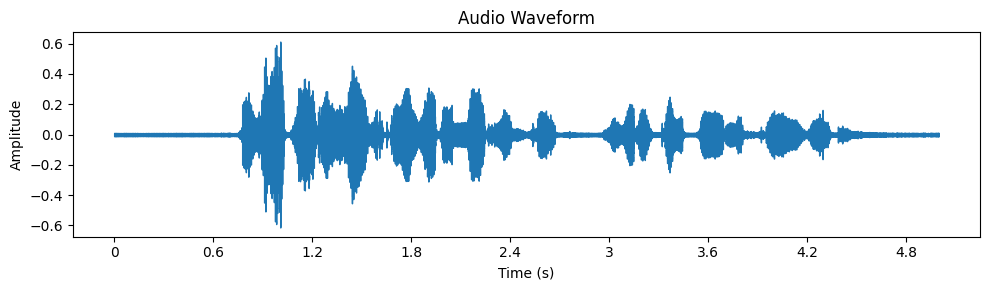

In [27]:
# example visualization of a single audio observation of the American_English class

audio_path = '/content/drive/MyDrive/Machine Learning/Final Project/balanced_voxforge_subset/American_English_0/wav/a0096.wav'
signal, sr = librosa.load(audio_path, sr=None)

mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 3))
librosa.display.waveshow(signal, sr=sr)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

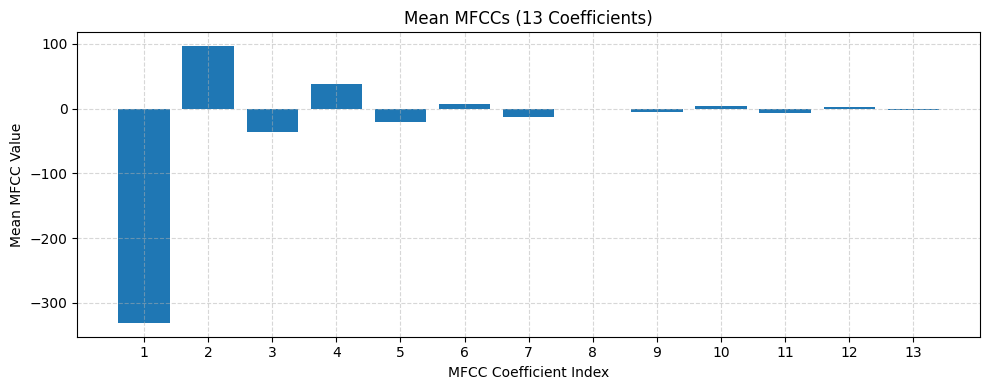

In [28]:
# visualization of the mean MFCC for the 13 coeffecients that we use later for model training

mean_mfcc = np.mean(mfccs, axis=1)

plt.figure(figsize=(10, 4))
plt.bar(np.arange(1, 14), mean_mfcc)
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('Mean MFCC Value')
plt.title('Mean MFCCs (13 Coefficients)')
plt.xticks(np.arange(1, 14))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

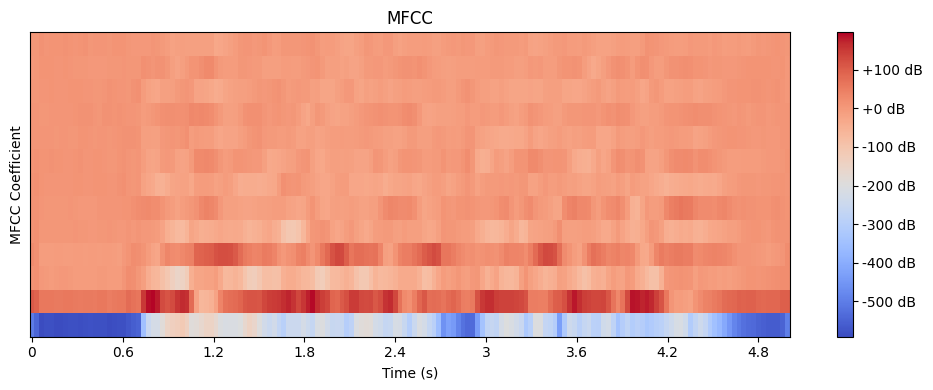

In [29]:
# visulaization of complete MFCC feature extraction for named sample

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.ylabel('MFCC Coefficient')
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

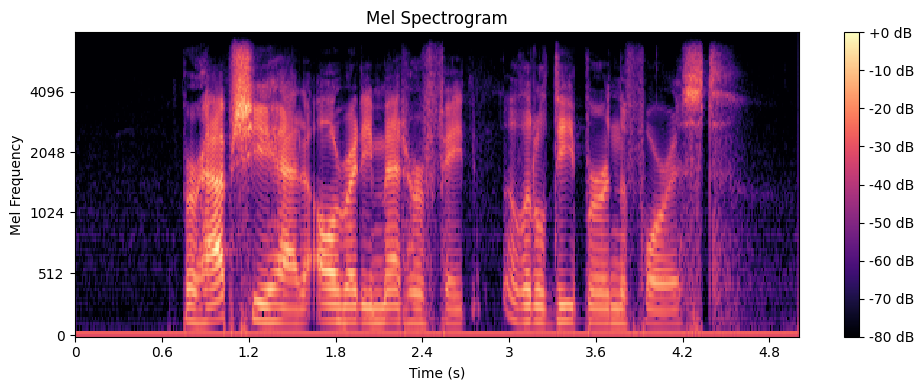

In [31]:
# visulaization of complete Mel Spectrogram for named sample

hop_length = int(0.01 * sr)
n_fft = int(0.025 * sr)
S = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()

Here we explore the durations of the audio samples we have: the resulting vector contains all of the durations of the audio samples within our dataset.

In [ ]:
DATASET_DIR = '/content/drive/MyDrive/ML_sp25/Final Project/balanced_voxforge_subset'


def extract_duration(data_dir):
    dur = []
    for folder in os.listdir(data_dir):
        label = " ".join(folder.split('_')[:-1])
        folder_path = os.path.join(data_dir, folder, 'wav')
        if not os.path.exists(folder_path): continue

        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                try:
                    audio_path = os.path.join(folder_path, file)
                    dur.append(librosa.get_duration(path=audio_path))

                except Exception as e:
                    print(f"Failed on {file}: {e}")
    return dur

[5.376,
 4.6933125,
 4.0106875,
 3.4133125,
 6.2293125,
 5.8026875,
 4.7786875,
 4.5226875,
 3.7546875,
 6.656,
 4.0,
 4.624375,
 3.8388125,
 2.8565625,
 3.2129375,
 2.83775,
 2.5098125,
 2.193625,
 3.39325,
 3.950625,
 3.8744375,
 3.625,
 3.75,
 4.75,
 6.125,
 4.757875,
 3.375,
 4.375,
 3.078375,
 2.75,
 4.25,
 4.75,
 4.125,
 6.125,
 7.0,
 5.75,
 7.75,
 5.875,
 3.75,
 5.0,
 2.75,
 3.875,
 2.875,
 3.75,
 4.125,
 3.875,
 4.25,
 3.625,
 3.625,
 4.5,
 4.0106875,
 4.864,
 2.645375,
 4.693375,
 5.717375,
 4.608,
 5.5466875,
 2.816,
 3.584,
 4.7786875,
 3.0,
 4.75,
 4.125,
 2.75,
 3.5,
 2.75,
 3.5,
 4.625,
 2.125,
 2.625,
 5.5,
 5.375,
 4.5,
 4.75,
 3.625,
 4.75,
 3.875,
 4.375,
 3.125,
 4.125,
 2.625,
 2.75,
 4.125,
 2.875,
 3.625,
 3.875,
 3.5,
 4.625,
 4.0,
 3.5,
 7.375,
 6.375,
 4.875,
 4.375,
 7.125,
 7.25,
 7.125,
 7.375,
 7.25,
 7.0,
 8.25,
 6.125,
 7.125,
 6.0,
 5.875,
 4.375,
 5.625,
 3.75,
 5.0,
 3.5,
 34.75,
 47.75,
 24.125,
 34.875,
 23.75,
 34.75,
 39.75,
 31.0,
 40.25,
 32.375,

In [ ]:
durations = extract_duration(DATASET_DIR)
plt.hist(durations)
plt.title("A Histogram of the Durations of Audio Samples in our Dataset")
plt.xlabel('Duration')
plt.ylabel('Count')

Since the audios are of varying lengths, so for our intial methods we will take a mean and we will standardize the length for our neural net methods. The following chunk was used to generate a dataset containing the time averaged MFCC coeffecient vectors for each sample.

In [ ]:

#No need to run since features are saved locally
DATASET_DIR = '/content/drive/MyDrive/Machine Learning/Final Project/balanced_voxforge_subset'


def extract_features(data_dir, n_mfcc=13):
    X, y = [], []
    for folder in os.listdir(data_dir):
        label = " ".join(folder.split('_')[:-1])
        folder_path = os.path.join(data_dir, folder, 'wav')
        if not os.path.exists(folder_path): continue

        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                try:
                    audio_path = os.path.join(folder_path, file)
                    signal, sr = librosa.load(audio_path, sr=None)
                    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
                    mfccs_mean = np.mean(mfccs.T, axis=0)  # Take time averaged mfccs
                    X.append(mfccs_mean)
                    y.append(label)
                except Exception as e:
                    print(f"Failed on {file}: {e}")
    return np.array(X), np.array(y)


X, y = extract_features(DATASET_DIR)
np.save('/content/drive/MyDrive/Machine Learning/Final Project/X_mfcc.npy', X)
np.save('/content/drive/MyDrive/Machine Learning/Final Project/y_labels.npy', y)



KeyboardInterrupt: 

Below is an example of a single observation in the resulting dataset from the execution of the above code as well as it's corrresponding label.

In [35]:
X = np.load('/content/drive/MyDrive/Machine Learning/Final Project/X_mfcc.npy')
X[0]

array([-508.04666 ,   72.94509 ,  -12.654263,   23.051117,  -32.088684,
         18.82835 ,   -9.085449,   15.637469,  -12.684749,    5.293887,
        -14.65461 ,    9.395991,  -10.709298], dtype=float32)

In [36]:
y = np.load('/content/drive/MyDrive/Machine Learning/Final Project/y_labels.npy')
y[0]

np.str_('Canadian English')

In [41]:
# change this to your drive path and after mounting drive to access the extracted features from our data
X = np.load('/content/drive/MyDrive/Machine Learning/Final Project/X_mfcc.npy')
y = np.load('/content/drive/MyDrive/Machine Learning/Final Project/y_labels.npy', allow_pickle=True)

# encode labels from text to numbers so maps each accent to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Report")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

Logistic Regression Report
                  precision    recall  f1-score   support

American English       0.45      0.46      0.46       399
Canadian English       0.49      0.47      0.48       391
European English       0.47      0.49      0.48       403

        accuracy                           0.47      1193
       macro avg       0.47      0.47      0.47      1193
    weighted avg       0.47      0.47      0.47      1193



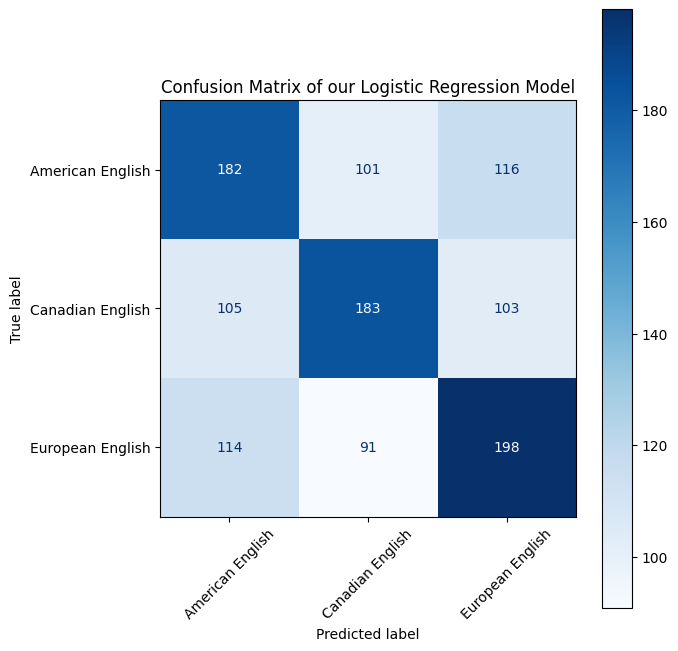

In [43]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
labels = le.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=labels)
fig, ax = plt.subplots(figsize=(7, 7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title('Confusion Matrix of our Logistic Regression Model')
plt.tight_layout()
plt.show()

In [44]:
svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Report")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

SVM Report
                  precision    recall  f1-score   support

American English       0.86      0.87      0.87       399
Canadian English       0.90      0.88      0.89       391
European English       0.90      0.90      0.90       403

        accuracy                           0.89      1193
       macro avg       0.89      0.89      0.89      1193
    weighted avg       0.89      0.89      0.89      1193



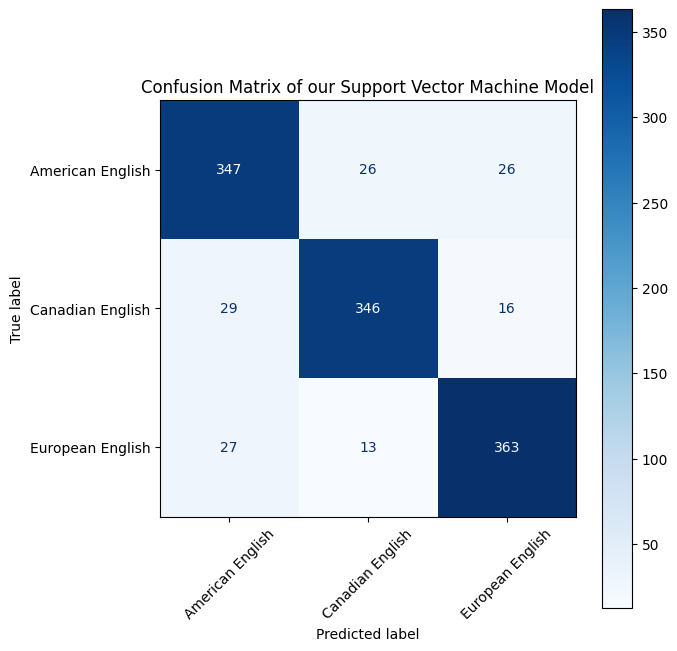

In [45]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
labels = le.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=labels)
fig, ax = plt.subplots(figsize=(7, 7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title('Confusion Matrix of our Support Vector Machine Model')
plt.tight_layout()
plt.show()

In [38]:
# Our initial Feed forward network trained on the mean MFCC coeffecients accroass the entire durationof the audio

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
def build_ff():
  nn_model = Sequential([
      Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(len(le.classes_), activation='softmax')
  ])

  return nn_model

In [39]:
nn_model = build_ff()
nn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,555 (13.89 KB)

 Trainable params: 3,555 (13.89 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn_model_history = nn_model.fit(X_train, y_train_cat, epochs=40, batch_size=32, validation_split=0.2, verbose=1)

# evaluate and print report
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_nn, target_names=le.classes_))

Epoch 1/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4476 - loss: 1.0776 - val_accuracy: 0.5210 - val_loss: 0.9899
Epoch 2/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5674 - loss: 0.9443 - val_accuracy: 0.5681 - val_loss: 0.9163
Epoch 3/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6186 - loss: 0.8581 - val_accuracy: 0.6069 - val_loss: 0.8673
Epoch 4/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6514 - loss: 0.7872 - val_accuracy: 0.6268 - val_loss: 0.8175
Epoch 5/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6910 - loss: 0.7387 - val_accuracy: 0.6751 - val_loss: 0.7740
Epoch 6/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7057 - loss: 0.7075 - val_accuracy: 0.6929 - val_loss: 0.7462
Epoch 7/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7068 - loss: 0.6795 - val_accuracy: 0.6950 - val_loss: 0.7204
Epoch 8/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7395 - loss: 0.6281 - val_accuracy: 0.

In [ ]:
#random test
test1, sr = librosa.load('/content/drive/MyDrive/Machine Learning/Final Project/balanced_voxforge_subset/European_English_25/wav/a0230.wav', sr=None)
test2, sr = librosa.load('/content/drive/MyDrive/Machine Learning/Final Project/balanced_voxforge_subset/American_English_25/wav/a0539.wav', sr=None)
test3, sr = librosa.load('/content/drive/MyDrive/Machine Learning/Final Project/balanced_voxforge_subset/Canadian_English_25/wav/a0467.wav', sr=None)
x = librosa.feature.mfcc(y=test3, sr=sr, n_mfcc=13)
x_mean = np.mean(x.T, axis=0).reshape(1, -1)
x_scaled = scaler.transform(x_mean)
# the le thing encodes and decodes string to integer and viceversa so american is 0, canadian is 1 and european is 2
le.inverse_transform(np.argmax(nn_model.predict(x_scaled), axis=1))[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


np.str_('Canadian English')

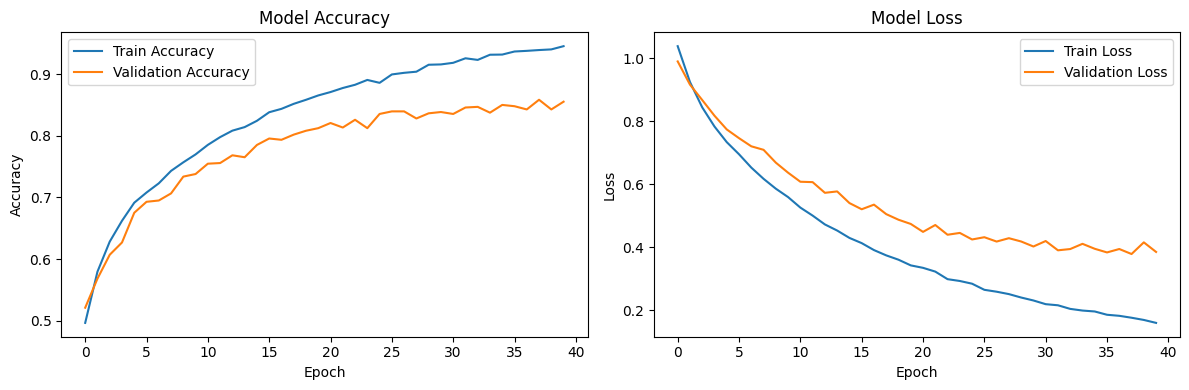

In [46]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(nn_model_history.history['accuracy'], label='Train Accuracy')
plt.plot(nn_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nn_model_history.history['loss'], label='Train Loss')
plt.plot(nn_model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


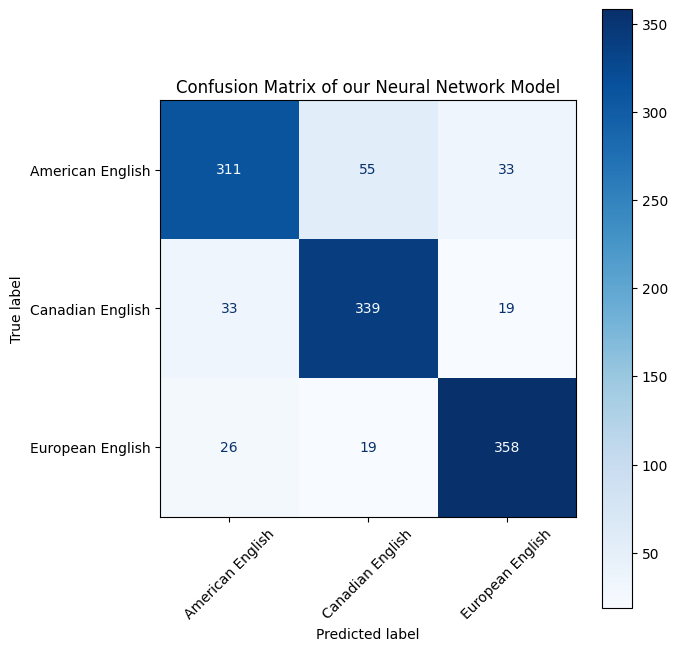

In [47]:
cm = confusion_matrix(y_test, y_pred_nn)
labels = le.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(7, 7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title('Confusion Matrix of our Neural Network Model')
plt.tight_layout()
plt.show()

### More complex model building:

After our initial experiments, we repeated feature extraction to obtain the overall MFCC and Mel Spectrogram features limited to 200 frames to facilitate training via Convolutional Neural Network-based architectures.

In [ ]:
def extract_mfcc_sequences(data_dir, n_mfcc=13, max_frames=200):
    X, y = [], []
    for folder in os.listdir(data_dir):
        label = " ".join(folder.split('_')[:-1])
        folder_path = os.path.join(data_dir, folder, 'wav')
        if not os.path.exists(folder_path): continue

        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                try:
                    audio_path = os.path.join(folder_path, file)
                    signal, sr = librosa.load(audio_path, sr=None)
                    # extract MFCCs
                    hop_length = int(0.01 * sr)
                    n_fft = int(0.025 * sr)
                    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
                    mfccs = mfccs.T  # (time_steps, n_mfcc)

                    # pad or truncate to max_frames
                    # this makes it such that each audio file is effectively of the same duration
                    if mfccs.shape[0] < max_frames:
                        pad_width = max_frames - mfccs.shape[0]
                        mfccs = np.pad(mfccs, ((0, pad_width), (0, 0)), mode='constant')
                    else:
                        mfccs = mfccs[:max_frames, :]

                    # add channel dimension to make the MFCCs image-like
                    mfccs = np.expand_dims(mfccs, axis=-1)

                    X.append(mfccs)
                    y.append(label)
                except Exception as e:
                    print(f"Failed on {file}: {e}")

    return np.array(X), np.array(y)


In [ ]:
def generate_spectrogram_data(data_dir, max_frames=200, n_mels=128):
    X, y = [], []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder, 'wav')
        if not os.path.exists(folder_path):
            continue
        label = " ".join(folder.split('_')[:-1])

        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                try:
                    file_path = os.path.join(folder_path, file)
                    signal, sr = librosa.load(file_path, sr=None)
                    hop_length = int(0.01 * sr)
                    n_fft = int(0.025 * sr)

                    # extract mel spectrogram
                    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length)
                    S_db = librosa.power_to_db(S, ref=np.max)

                    # pad/truncate to 200 frames like we did for the mfcc data
                    if S_db.shape[1] < max_frames:
                        pad = max_frames - S_db.shape[1]
                        S_db = np.pad(S_db, ((0, 0), (0, pad)), mode='constant')
                    else:
                        S_db = S_db[:, :max_frames]

                    # make the data image-like
                    S_db = np.expand_dims(S_db.T, axis=-1)

                    X.append(S_db)
                    y.append(label)

                except Exception as e:
                    print(f"Failed on {file}: {e}")

    return np.array(X), np.array(y)

Preprocessing

In [ ]:
# extract features in new way
DATASET_DIR = '/content/drive/MyDrive/Machine Learning/Final Project/balanced_voxforge_subset'
X, y = generate_spectrogram_data(DATASET_DIR)
np.save('/content/drive/MyDrive/Machine Learning/Final Project/X_melspec_cnn.npy', X)
np.save('/content/drive/MyDrive/Machine Learning/Final Project/y_melspec_labels_cnn.npy', y)

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=400 is too large for input signal of length=200
  warnings.warn(


In [ ]:
# extract mel spectogram features to test aginst performance on mfcc
DATA_DIR = "/content/drive/MyDrive/Machine Learning/Final Project/balanced_voxforge_subset"
X, y = extract_mfcc_sequences(DATASET_DIR, n_mfcc=13, max_frames=200)
np.save('/content/drive/MyDrive/Machine Learning/Final Project/X_mfcc_cnn.npy', X)
np.save('/content/drive/MyDrive/Machine Learning/Final Project/y_labels_cnn.npy', y)

In [50]:
#Change this to your drive path and after mounting drive to access the extracted features from our data
X = np.load('/content/drive/MyDrive/Machine Learning/Final Project/X_melspec_mfcc_cnn.npy')
y = np.load('/content/drive/MyDrive/Machine Learning/Final Project/y_melspec_labels_cnn.npy', allow_pickle=True)

# encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# train-test split
from sklearn.model_selection import train_test_split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [9]:
#Change this to your drive path and after mounting drive to access the extracted features from our data
X_melspec = np.load('/content/drive/MyDrive/Machine Learning/Final Project/X_melspec_cnn.npy')
y_melspec = np.load('/content/drive/MyDrive/Machine Learning/Final Project/y_melspec_labels_cnn.npy', allow_pickle=True)

# encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_melspec_encoded = le.fit_transform(y_melspec)

# train-test split
from sklearn.model_selection import train_test_split
X_train_melspec, X_test_melspec, y_train_melspec, y_test_melspec = train_test_split(
    X_melspec, y_melspec_encoded, test_size=0.2, stratify=y_melspec_encoded, random_state=42
)

In [63]:
X_train_melspec[0].shape

(200, 128, 1)

### **The following code chunks funciton to build and test CNN-based models**

In [51]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



In [57]:
# train the base cnn model
input_shape = (200, 13, 1)
num_classes = len(le.classes_)

model = build_cnn_model(input_shape, num_classes)



history = model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=20,
    batch_size=32,
    verbose=2,
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
149/149 - 19s - 126ms/step - accuracy: 0.4159 - loss: 1.1683 - val_accuracy: 0.4677 - val_loss: 1.0386
Epoch 2/20
149/149 - 16s - 107ms/step - accuracy: 0.4941 - loss: 0.9915 - val_accuracy: 0.5608 - val_loss: 0.9517
Epoch 3/20
149/149 - 20s - 134ms/step - accuracy: 0.5549 - loss: 0.9082 - val_accuracy: 0.5641 - val_loss: 0.9052
Epoch 4/20
149/149 - 20s - 137ms/step - accuracy: 0.6026 - loss: 0.8435 - val_accuracy: 0.6035 - val_loss: 0.8266
Epoch 5/20
149/149 - 21s - 140ms/step - accuracy: 0.6367 - loss: 0.7659 - val_accuracy: 0.6002 - val_loss: 0.8494
Epoch 6/20
149/149 - 16s - 108ms/step - accuracy: 0.6831 - loss: 0.6957 - val_accuracy: 0.6521 - val_loss: 0.7805
Epoch 7/20
149/149 - 20s - 135ms/step - accuracy: 0.7253 - loss: 0.6181 - val_accuracy: 0.6664 - val_loss: 0.7722
Epoch 8/20
149/149 - 21s - 138ms/step - accuracy: 0.7485 - loss: 0.5632 - val_accuracy: 0.6002 - val_loss: 0.9674
Epoch 9/20
149/149 - 20s - 136ms/step - accuracy: 0.7947 - loss: 0.4805 - val_accuracy: 

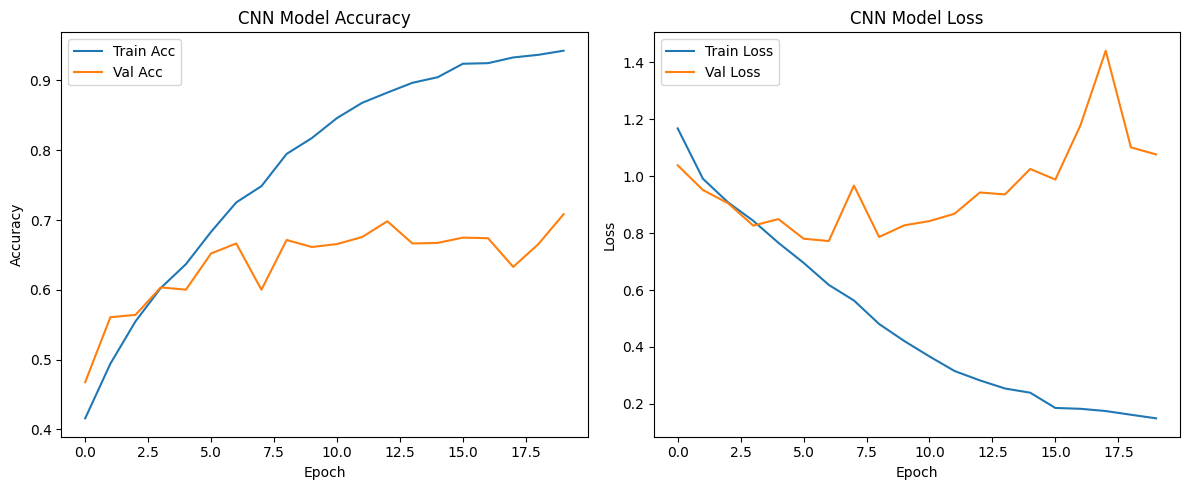

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
CNN Classification Report:
                  precision    recall  f1-score   support

American English       0.66      0.77      0.71       399
Canadian English       0.78      0.59      0.67       391
European English       0.71      0.76      0.73       403

        accuracy                           0.71      1193
       macro avg       0.72      0.71      0.71      1193
    weighted avg       0.72      0.71      0.71      1193



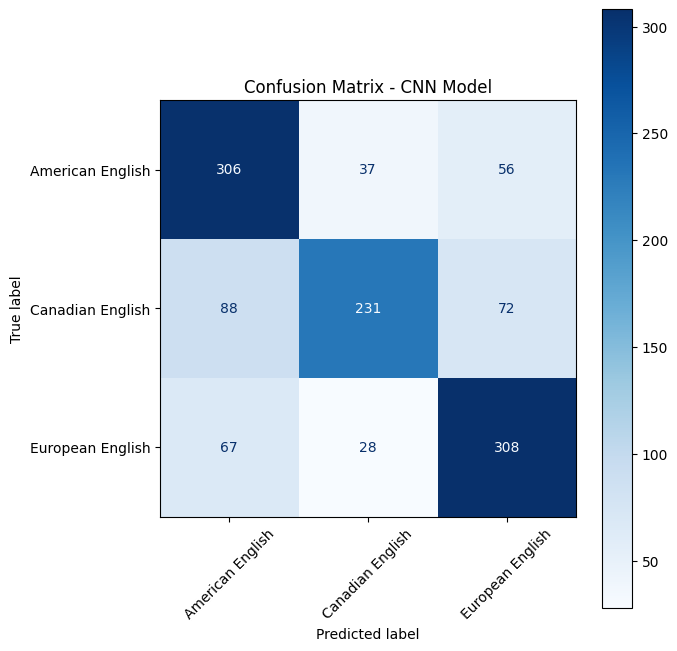

In [60]:
# plot loss, accuracy, and confusion matrix
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Model Loss')
plt.legend()

plt.tight_layout()
plt.show()


y_pred_cnn = np.argmax(model.predict(X_test_cnn), axis=1)
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn, target_names=le.classes_))

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - CNN Model")
plt.tight_layout()
plt.show()


In [86]:
# retrain the base cnn model on mel spectrogram data
input_shape = (200, 128, 1)
num_classes = len(le.classes_)

model_melspec = build_cnn_model(input_shape, num_classes)

history_melspec = model_melspec.fit(
    X_train_melspec, y_train_melspec,
    validation_data=(X_test_melspec, y_test_melspec),
    epochs=10,
    batch_size=32,
    verbose=2,
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
149/149 - 324s - 2s/step - accuracy: 0.3301 - loss: 1.8732 - val_accuracy: 0.3336 - val_loss: 1.6783
Epoch 2/10
149/149 - 324s - 2s/step - accuracy: 0.3469 - loss: 1.0968 - val_accuracy: 0.3286 - val_loss: 1.8447
Epoch 3/10
149/149 - 382s - 3s/step - accuracy: 0.3358 - loss: 1.0938 - val_accuracy: 0.3311 - val_loss: 1.7323
Epoch 4/10
149/149 - 384s - 3s/step - accuracy: 0.3410 - loss: 1.0930 - val_accuracy: 0.3395 - val_loss: 1.1019
Epoch 5/10
149/149 - 380s - 3s/step - accuracy: 0.3448 - loss: 1.0922 - val_accuracy: 0.3336 - val_loss: 10.4504
Epoch 6/10
149/149 - 323s - 2s/step - accuracy: 0.3431 - loss: 1.0923 - val_accuracy: 0.3353 - val_loss: 7.4254
Epoch 7/10
149/149 - 326s - 2s/step - accuracy: 0.3438 - loss: 1.0912 - val_accuracy: 0.3319 - val_loss: 3.6009
Epoch 8/10
149/149 - 383s - 3s/step - accuracy: 0.3427 - loss: 1.0915 - val_accuracy: 0.3277 - val_loss: 65.6574
Epoch 9/10
149/149 - 380s - 3s/step - accuracy: 0.3347 - loss: 1.0931 - val_accuracy: 0.3378 - val_los

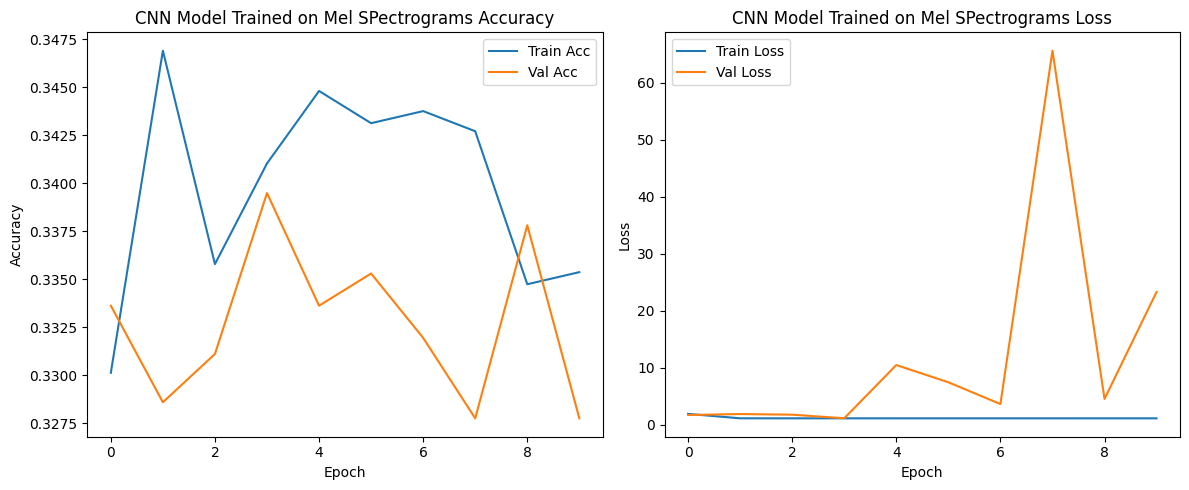

38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 359ms/step
CNN Classification Report:
                  precision    recall  f1-score   support

American English       0.34      0.81      0.48       399
Canadian English       0.00      0.00      0.00       391
European English       0.30      0.17      0.22       403

        accuracy                           0.33      1193
       macro avg       0.21      0.33      0.23      1193
    weighted avg       0.21      0.33      0.23      1193



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


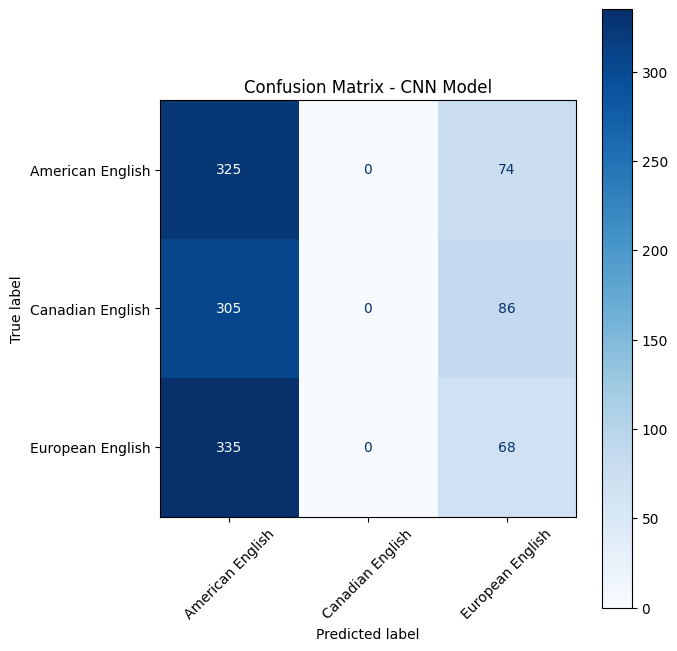

In [87]:
# plot loss, accuracy, and confusion matrix
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_melspec.history['accuracy'], label='Train Acc')
plt.plot(history_melspec.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model Trained on Mel SPectrograms Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_melspec.history['loss'], label='Train Loss')
plt.plot(history_melspec.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Model Trained on Mel SPectrograms Loss')
plt.legend()

plt.tight_layout()
plt.show()


y_pred_melspec = np.argmax(model.predict(X_test_melspec), axis=1)
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_melspec, target_names=le.classes_))

cm_melspec = confusion_matrix(y_test, y_pred_melspec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_melspec, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - CNN Model")
plt.tight_layout()
plt.show()


In [17]:
def build_cnn_rnn_model(input_shape, num_classes):
    """
    Builds a CNN-RNN hybrid model using the Functional API.
    """
    inputs = layers.Input(shape=input_shape)

    # CNN layers
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Now shape: (batch_size, time_steps_reduced, n_mfcc_reduced, filters)
    # Reshape for RNN: (batch_size, time_steps_reduced, n_mfcc_reduced * filters)
    shape = x.shape  # TensorShape object

    time_steps_reduced = shape[1]
    n_mfcc_reduced = shape[2]
    filters = shape[3]

    x = layers.Reshape((time_steps_reduced, n_mfcc_reduced * filters))(x)

    # RNN layer
    x = layers.LSTM(64, return_sequences=False)(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [69]:
input_shape = (200, 13, 1)
num_classes = len(le.classes_)
model_cnn_rnn = build_cnn_rnn_model(input_shape, num_classes)
model_cnn_rnn.summary()

Model: "functional_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 200, 13, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 200, 13, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 200, 13, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 100, 6, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 100, 6, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 100, 6, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 50, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 50, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,699 (366.01 KB)

 Trainable params: 93,507 (365.26 KB)

 Non-trainable params: 192 (768.00 B)

In [70]:
history_cnn_rnn = model_cnn_rnn.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=10,
    batch_size=32,
    verbose=2
)


Epoch 1/10
149/149 - 34s - 230ms/step - accuracy: 0.3700 - loss: 1.1008 - val_accuracy: 0.3571 - val_loss: 1.1036
Epoch 2/10
149/149 - 40s - 271ms/step - accuracy: 0.4165 - loss: 1.0737 - val_accuracy: 0.3965 - val_loss: 1.0654
Epoch 3/10
149/149 - 41s - 274ms/step - accuracy: 0.4708 - loss: 1.0357 - val_accuracy: 0.4753 - val_loss: 1.0191
Epoch 4/10
149/149 - 29s - 192ms/step - accuracy: 0.5176 - loss: 0.9732 - val_accuracy: 0.5356 - val_loss: 0.9578
Epoch 5/10
149/149 - 42s - 284ms/step - accuracy: 0.5587 - loss: 0.9106 - val_accuracy: 0.5717 - val_loss: 0.9055
Epoch 6/10
149/149 - 29s - 197ms/step - accuracy: 0.5986 - loss: 0.8579 - val_accuracy: 0.5507 - val_loss: 0.9074
Epoch 7/10
149/149 - 40s - 272ms/step - accuracy: 0.6198 - loss: 0.8208 - val_accuracy: 0.6337 - val_loss: 0.8135
Epoch 8/10
149/149 - 41s - 277ms/step - accuracy: 0.6483 - loss: 0.7667 - val_accuracy: 0.6329 - val_loss: 0.8134
Epoch 9/10
149/149 - 29s - 194ms/step - accuracy: 0.6850 - loss: 0.7075 - val_accuracy: 

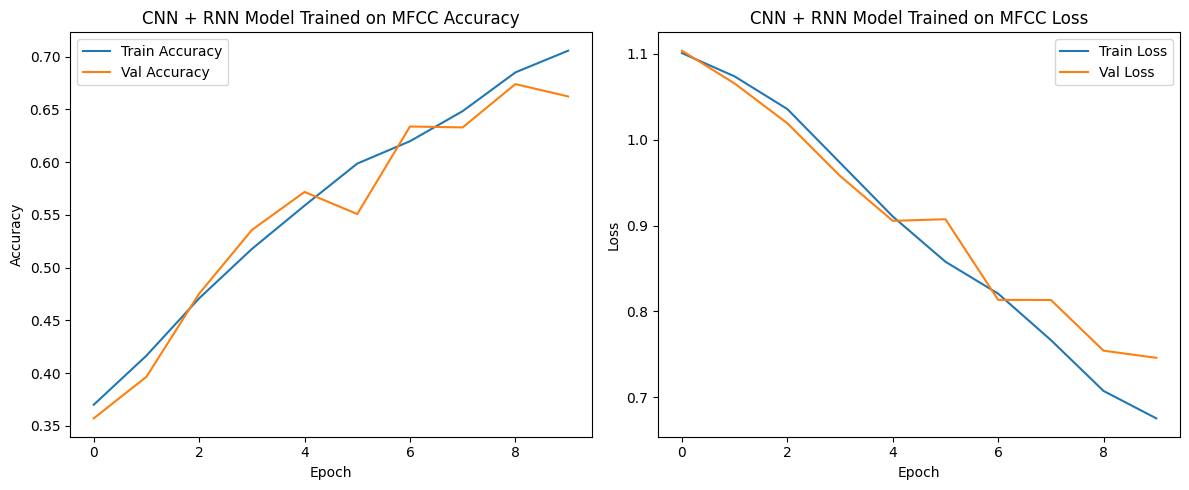

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step
CNN Classification Report:
                  precision    recall  f1-score   support

American English       0.59      0.62      0.61       399
Canadian English       0.67      0.70      0.68       391
European English       0.74      0.67      0.70       403

        accuracy                           0.66      1193
       macro avg       0.67      0.66      0.66      1193
    weighted avg       0.67      0.66      0.66      1193



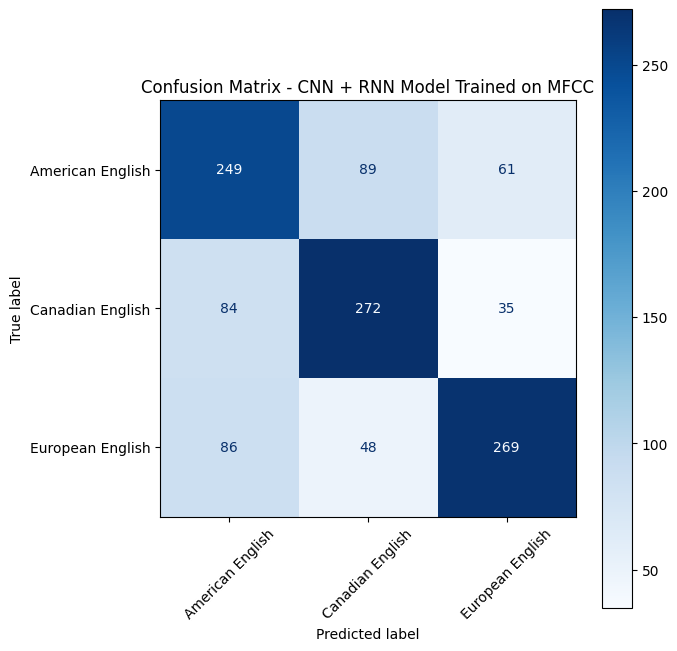

In [72]:
plt.figure(figsize=(12,5))

# plot loss, accuracy, and confusio matrix
plt.subplot(1,2,1)
plt.plot(history_cnn_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_rnn.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN + RNN Model Trained on MFCC Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn_rnn.history['loss'], label='Train Loss')
plt.plot(history_cnn_rnn.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN + RNN Model Trained on MFCC Loss')
plt.legend()

plt.tight_layout()
plt.show()

y_pred_cnn_rnn = np.argmax(model_cnn_rnn.predict(X_test_cnn), axis=1)
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn_rnn, target_names=le.classes_))

cm_cnn_rnn = confusion_matrix(y_test, y_pred_cnn_rnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_rnn, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - CNN + RNN Model Trained on MFCC")
plt.tight_layout()
plt.show()

In [19]:
# making CNN + RNN model for melspec data
input_shape = (200, 128, 1)
num_classes = len(le.classes_)
model_cnn_rnn_melspec = build_cnn_rnn_model(input_shape, num_classes)
model_cnn_rnn_melspec.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 200, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 100, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 64, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 568,835 (2.17 MB)

 Trainable params: 568,643 (2.17 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
history_cnn_rnn_melspec = model_cnn_rnn_melspec.fit(
    X_train_melspec, y_train_melspec,
    validation_data=(X_test_melspec, y_test_melspec),
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10
149/149 - 371s - 2s/step - accuracy: 0.3280 - loss: 1.1076 - val_accuracy: 0.3345 - val_loss: 1.0991
Epoch 2/10
149/149 - 360s - 2s/step - accuracy: 0.3314 - loss: 1.1002 - val_accuracy: 0.3277 - val_loss: 1.0987
Epoch 3/10
149/149 - 347s - 2s/step - accuracy: 0.3280 - loss: 1.0992 - val_accuracy: 0.3345 - val_loss: 1.0986
Epoch 4/10
149/149 - 384s - 3s/step - accuracy: 0.3293 - loss: 1.0991 - val_accuracy: 0.3345 - val_loss: 1.0986
Epoch 5/10
149/149 - 384s - 3s/step - accuracy: 0.3297 - loss: 1.0989 - val_accuracy: 0.3378 - val_loss: 1.0986
Epoch 6/10
149/149 - 379s - 3s/step - accuracy: 0.3362 - loss: 1.0988 - val_accuracy: 0.3378 - val_loss: 1.0985
Epoch 7/10
149/149 - 353s - 2s/step - accuracy: 0.3366 - loss: 1.0987 - val_accuracy: 0.3378 - val_loss: 1.0985
Epoch 8/10
149/149 - 377s - 3s/step - accuracy: 0.3385 - loss: 1.0987 - val_accuracy: 0.3378 - val_loss: 1.0985
Epoch 9/10
149/149 - 350s - 2s/step - accuracy: 0.3381 - loss: 1.0987 - val_accuracy: 0.3378 - val_loss:

In [ ]:
plt.figure(figsize=(12,5))

# plot loss, accuracy, and confusio matrix
plt.subplot(1,2,1)
plt.plot(history_cnn_rnn_melspec.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_rnn_melspec.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN + RNN Model Trained on Mel Spectograms Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn_rnn_melspec.history['loss'], label='Train Loss')
plt.plot(history_cnn_rnn_melspec.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN + RNN Model Trained on Mel Spectograms Loss')
plt.legend()

plt.tight_layout()
plt.show()

y_pred_cnn_rnn_melspec = np.argmax(model.predict(X_test_melspec), axis=1)
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn_rnn_melspec, target_names=le.classes_))

cm_cnn_rnn_melspec = confusion_matrix(y_test, y_pred_cnn_rnn_melspec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_rnn_melspec, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - CNN + RNN Model Trained on Mel Spectograms")
plt.tight_layout()
plt.show()

Updated CNN with Regularization

In [74]:
def build_cnn_rnn_model(input_shape, num_classes):
    """
    Builds a CNN-RNN hybrid model using the Functional API with enhanced regularization and adjusted capacity.
    """
    l2_strength = 1e-6  # reduced regularization to help with underfitting

    inputs = layers.Input(shape=input_shape)

    # CNN layers with L-2 regularization and increased filters
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_strength))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_strength))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # reshape for RNN
    shape = x.shape
    time_steps_reduced = shape[1]
    n_mfcc_reduced = shape[2]
    filters = shape[3]

    x = layers.Reshape((time_steps_reduced, n_mfcc_reduced * filters))(x)

    # RNN layer with L-2 regularization and moderate dropout
    x = layers.LSTM(64, return_sequences=False,
                    kernel_regularizer=regularizers.l2(l2_strength),
                    recurrent_regularizer=regularizers.l2(l2_strength),
                    dropout=0.4, recurrent_dropout=0.4)(x)

    # dense layers with L2 regularization and moderate dropout
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_strength))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [75]:
input_shape = (200, 13, 1)
num_classes = len(le.classes_)
model_cnn_rnn_reg = build_cnn_rnn_model(input_shape, num_classes)
model_cnn_rnn_reg.summary()

Model: "functional_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 200, 13, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 200, 13, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 200, 13, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 100, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 100, 6, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 100, 6, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 50, 3, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 50, 384)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │       114,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,915 (777.01 KB)

 Trainable params: 198,531 (775.51 KB)

 Non-trainable params: 384 (1.50 KB)

In [76]:

history_cnn_rnn_reg = model_cnn_rnn_reg.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10
149/149 - 188s - 1s/step - accuracy: 0.3364 - loss: 1.1171 - val_accuracy: 0.3705 - val_loss: 1.0958
Epoch 2/10
149/149 - 72s - 484ms/step - accuracy: 0.3542 - loss: 1.0997 - val_accuracy: 0.3537 - val_loss: 1.0936
Epoch 3/10
149/149 - 84s - 566ms/step - accuracy: 0.3589 - loss: 1.0989 - val_accuracy: 0.3847 - val_loss: 1.0920
Epoch 4/10
149/149 - 78s - 527ms/step - accuracy: 0.3826 - loss: 1.0904 - val_accuracy: 0.3982 - val_loss: 1.0799
Epoch 5/10
149/149 - 82s - 550ms/step - accuracy: 0.4107 - loss: 1.0795 - val_accuracy: 0.4350 - val_loss: 1.0591
Epoch 6/10
149/149 - 83s - 558ms/step - accuracy: 0.4157 - loss: 1.0745 - val_accuracy: 0.4518 - val_loss: 1.0559
Epoch 7/10
149/149 - 88s - 593ms/step - accuracy: 0.4348 - loss: 1.0594 - val_accuracy: 0.4644 - val_loss: 1.0434
Epoch 8/10
149/149 - 77s - 519ms/step - accuracy: 0.4641 - loss: 1.0380 - val_accuracy: 0.4769 - val_loss: 1.0107
Epoch 9/10
149/149 - 81s - 543ms/step - accuracy: 0.4880 - loss: 1.0209 - val_accuracy: 0.

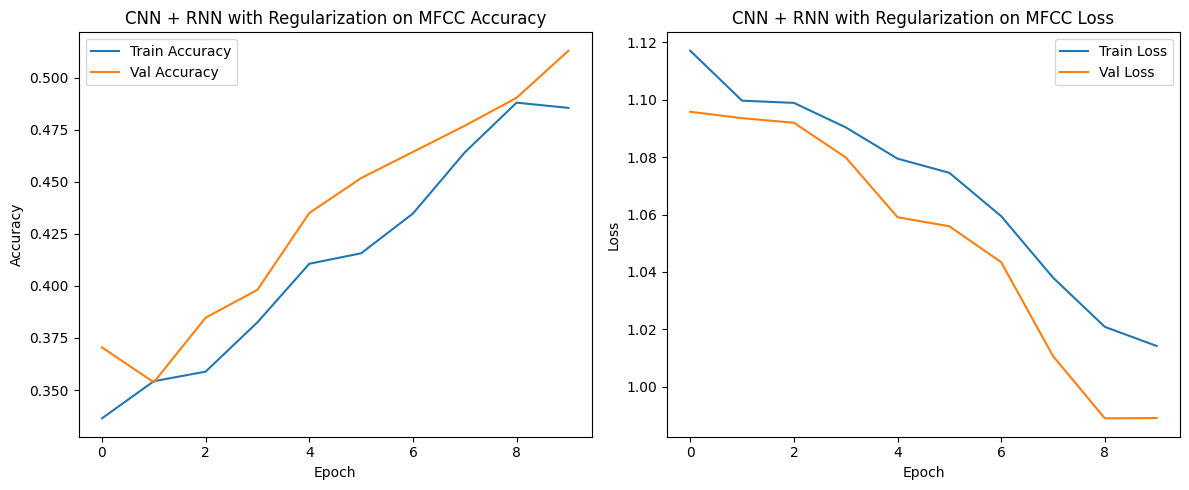

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step
                  precision    recall  f1-score   support

American English       0.50      0.46      0.48       399
Canadian English       0.63      0.36      0.45       391
European English       0.48      0.72      0.57       403

        accuracy                           0.51      1193
       macro avg       0.54      0.51      0.50      1193
    weighted avg       0.54      0.51      0.50      1193



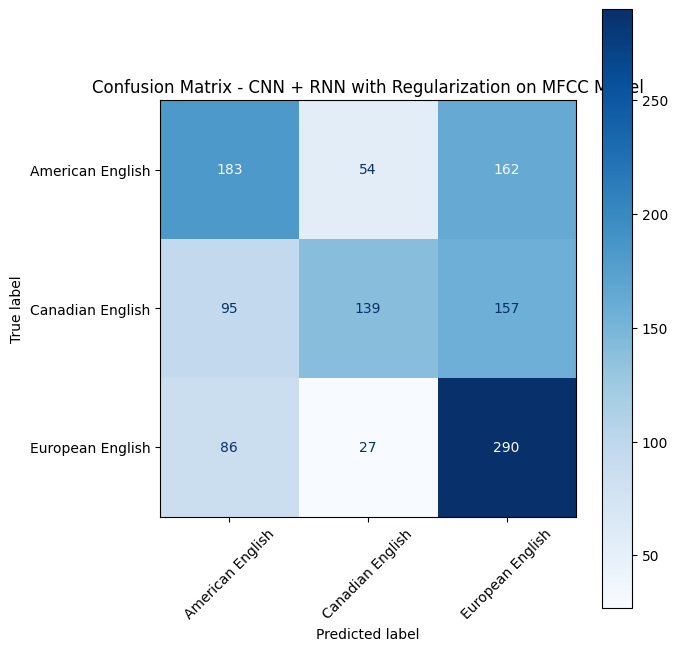

In [77]:
plt.figure(figsize=(12,5))

# accuracy plot
plt.subplot(1,2,1)
plt.plot(history_cnn_rnn_reg.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_rnn_reg.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN + RNN with Regularization on MFCC Accuracy')
plt.legend()

# loss plot
plt.subplot(1,2,2)
plt.plot(history_cnn_rnn_reg.history['loss'], label='Train Loss')
plt.plot(history_cnn_rnn_reg.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN + RNN with Regularization on MFCC Loss')
plt.legend()

plt.tight_layout()
plt.show()

# evaluate
y_pred_cnn_rnn_reg = np.argmax(model_cnn_rnn_reg.predict(X_test_cnn), axis=1)
print(classification_report(y_test, y_pred_cnn_rnn_reg, target_names=le.classes_))

# confusion matrix
cm_cnn_rnn_reg = confusion_matrix(y_test, y_pred_cnn_rnn_reg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_rnn_reg, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - CNN + RNN with Regularization on MFCC Model")
plt.tight_layout()
plt.show()

In [ ]:
input_shape = (200, 128, 1)
num_classes = len(le.classes_)
model_cnn_rnn_reg_melspec = build_cnn_rnn_model(input_shape, num_classes)
model_cnn_rnn_reg_melspec.summary()

In [ ]:

history_cnn_rnn_reg_melspec = model_cnn_rnn_reg_melspec.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_melspec, y_test_melspec),
    epochs=10,
    batch_size=32,
    verbose=2
)

In [ ]:
plt.figure(figsize=(12,5))

# accuracy plot
plt.subplot(1,2,1)
plt.plot(history_cnn_rnn_reg_melspec.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_rnn_reg_melspec.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN + RNN with Regularization on Mel Spectrogram Accuracy')
plt.legend()

# loss plot
plt.subplot(1,2,2)
plt.plot(history_cnn_rnn_reg_melspec.history['loss'], label='Train Loss')
plt.plot(history_cnn_rnn_reg_melspec.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN + RNN with Regularization on Mel Spectrogram Loss')
plt.legend()

plt.tight_layout()
plt.show()

# evaluate
y_pred_cnn_rnn_reg_melspec = np.argmax(model_cnn_rnn_reg_melspec.predict(X_test_melspec), axis=1)
print(classification_report(y_test, y_pred_cnn_rnn_reg_melspec, target_names=le.classes_))

# confusion matrix
cm_cnn_rnn_reg_melspec = confusion_matrix(y_test, y_pred_cnn_rnn_reg_melspec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_rnn_reg_melspec, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - CNN + RNN with Regularization on Mel Spectrogram Model")
plt.tight_layout()
plt.show()

VFNet

In [4]:
def build_vfnet(input_shape, num_classes, filter_list):
  """
  Implements the varibale filter CNN architecture introduced in Ahmed et al.'s paper at https://ieeexplore.ieee.org/document/9030363
  """

  filter_layers = []

  input_layer = Input(shape=input_shape)
  for i in filter_list:
    # parallel convolutions to implement variable filter sizes
    conv_layer = Conv2D(filters=32, kernel_size=i, padding='same', activation='relu')(input_layer)
    filter_layers.append(conv_layer)

  # combine convolutional layers
  merged_conv = Concatenate()(filter_layers)

  # max pool and classify
  pooled = MaxPooling2D((2,2))(merged_conv)
  flat = Flatten()(pooled)
  dense = Dense(64, activation='relu')(flat)
  output = Dense(num_classes, activation='softmax')(dense)

  model = Model(inputs=input_layer, outputs=output)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [5]:
input_shape = (200, 13, 1)
num_classes = len(le.classes_)
filters=[3, 5, 7]
model_vfnet_cnn = build_vfnet(input_shape, num_classes, filters)

NameError: name 'le' is not defined

In [83]:
history_vfnet_cnn = model_vfnet_cnn.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10
149/149 - 40s - 271ms/step - accuracy: 0.3698 - loss: 55.3305 - val_accuracy: 0.4300 - val_loss: 6.8192
Epoch 2/10
149/149 - 41s - 277ms/step - accuracy: 0.4417 - loss: 5.8707 - val_accuracy: 0.4292 - val_loss: 3.4815
Epoch 3/10
149/149 - 39s - 263ms/step - accuracy: 0.5755 - loss: 1.8253 - val_accuracy: 0.4007 - val_loss: 3.9405
Epoch 4/10
149/149 - 37s - 248ms/step - accuracy: 0.6030 - loss: 1.8559 - val_accuracy: 0.4786 - val_loss: 2.3031
Epoch 5/10
149/149 - 38s - 252ms/step - accuracy: 0.6596 - loss: 1.2862 - val_accuracy: 0.4233 - val_loss: 3.3913
Epoch 6/10
149/149 - 41s - 275ms/step - accuracy: 0.7022 - loss: 1.0844 - val_accuracy: 0.4686 - val_loss: 2.5442
Epoch 7/10
149/149 - 41s - 275ms/step - accuracy: 0.7527 - loss: 0.8065 - val_accuracy: 0.4828 - val_loss: 2.2860
Epoch 8/10
149/149 - 38s - 258ms/step - accuracy: 0.7177 - loss: 1.1637 - val_accuracy: 0.4208 - val_loss: 4.8150
Epoch 9/10
149/149 - 41s - 274ms/step - accuracy: 0.7412 - loss: 0.9007 - val_accuracy:

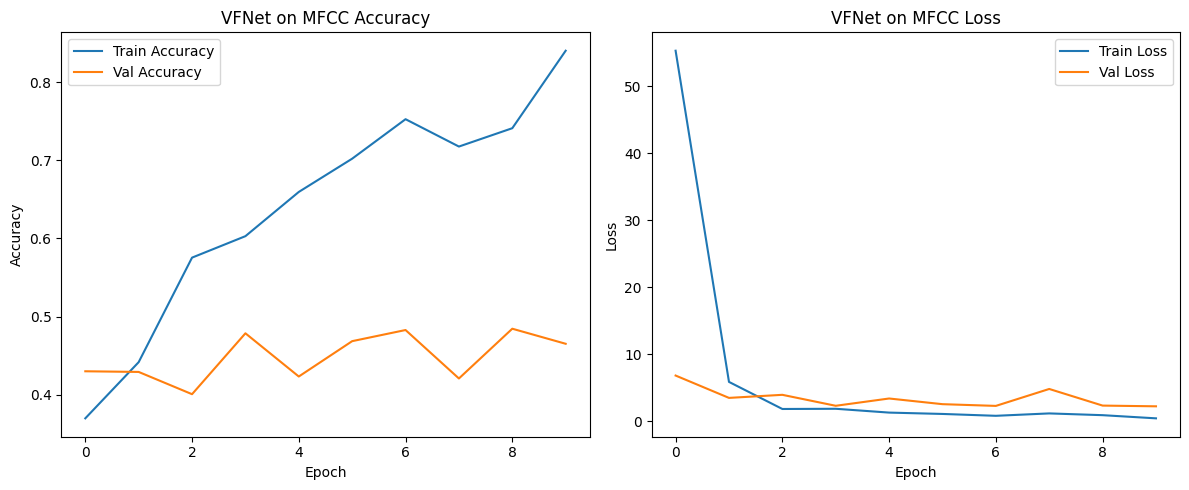

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step
                  precision    recall  f1-score   support

American English       0.40      0.71      0.52       399
Canadian English       0.54      0.35      0.42       391
European English       0.56      0.34      0.42       403

        accuracy                           0.47      1193
       macro avg       0.50      0.46      0.45      1193
    weighted avg       0.50      0.47      0.45      1193



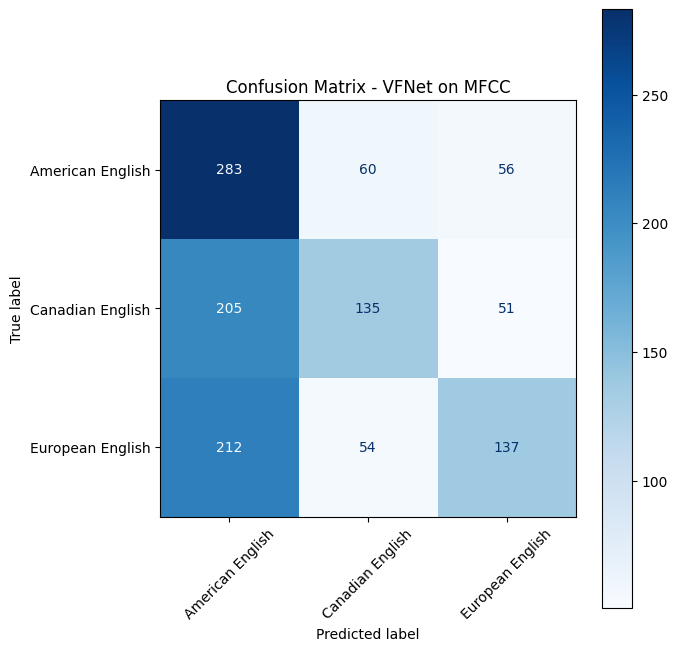

In [84]:
plt.figure(figsize=(12,5))

# accuracy plot
plt.subplot(1,2,1)
plt.plot(history_vfnet_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_vfnet_cnn.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VFNet on MFCC Accuracy')
plt.legend()

# loss plot
plt.subplot(1,2,2)
plt.plot(history_vfnet_cnn.history['loss'], label='Train Loss')
plt.plot(history_vfnet_cnn.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VFNet on MFCC Loss')
plt.legend()

plt.tight_layout()
plt.show()

# evaluate
y_pred_vfnet_cnn = np.argmax(model_vfnet_cnn.predict(X_test_cnn), axis=1)
print(classification_report(y_test, y_pred_vfnet_cnn, target_names=le.classes_))

# confusion matrix
cm_vfnet_cnn = confusion_matrix(y_test, y_pred_vfnet_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vfnet_cnn, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - VFNet on MFCC")
plt.tight_layout()
plt.show()

In [11]:
input_shape = (200, 128, 1)
num_classes = len(le.classes_)
filters=[3, 5, 7]
model_vfnet_melspec = build_vfnet(input_shape, num_classes, filters)

In [12]:
history_vfnet_melspec = model_vfnet_melspec.fit(
    X_train_melspec, y_train_melspec,
    validation_data=(X_test_melspec, y_test_melspec),
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10
149/149 - 452s - 3s/step - accuracy: 0.3777 - loss: 3.8805 - val_accuracy: 0.4384 - val_loss: 1.0674
Epoch 2/10
149/149 - 456s - 3s/step - accuracy: 0.4643 - loss: 1.0405 - val_accuracy: 0.4401 - val_loss: 1.0574
Epoch 3/10
149/149 - 449s - 3s/step - accuracy: 0.5019 - loss: 0.9959 - val_accuracy: 0.4283 - val_loss: 1.0954
Epoch 4/10
149/149 - 454s - 3s/step - accuracy: 0.5143 - loss: 0.9791 - val_accuracy: 0.4577 - val_loss: 1.0630
Epoch 5/10
149/149 - 502s - 3s/step - accuracy: 0.5508 - loss: 0.9384 - val_accuracy: 0.4728 - val_loss: 1.0714
Epoch 6/10
149/149 - 507s - 3s/step - accuracy: 0.5625 - loss: 0.9073 - val_accuracy: 0.4711 - val_loss: 1.0405
Epoch 7/10
149/149 - 491s - 3s/step - accuracy: 0.5812 - loss: 0.8851 - val_accuracy: 0.4803 - val_loss: 1.0261
Epoch 8/10
149/149 - 509s - 3s/step - accuracy: 0.5879 - loss: 0.8769 - val_accuracy: 0.4920 - val_loss: 1.0208
Epoch 9/10
149/149 - 501s - 3s/step - accuracy: 0.5998 - loss: 0.8556 - val_accuracy: 0.5004 - val_loss:

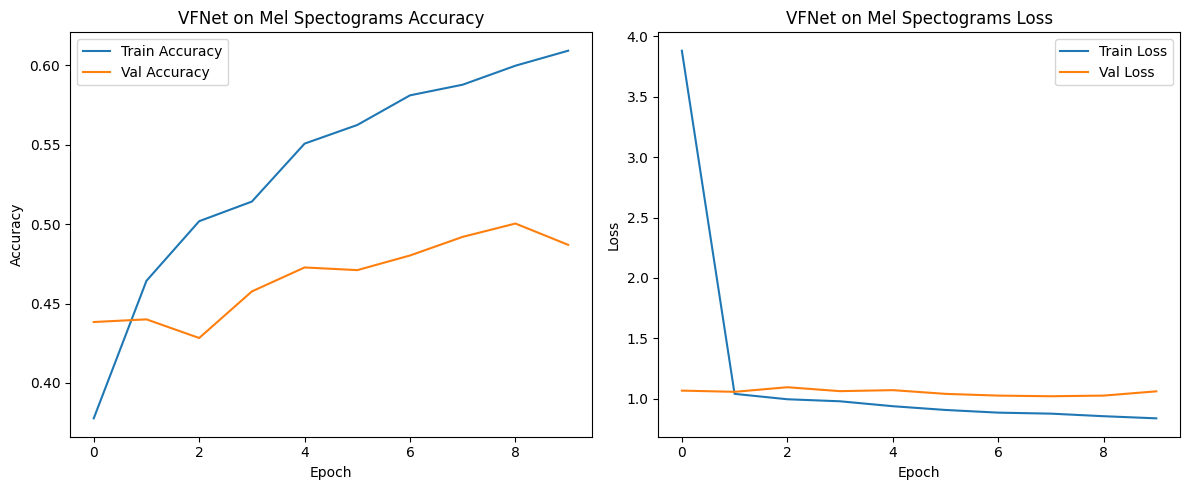

38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 935ms/step
                  precision    recall  f1-score   support

American English       0.44      0.52      0.48       399
Canadian English       0.49      0.61      0.54       391
European English       0.57      0.34      0.42       403

        accuracy                           0.49      1193
       macro avg       0.50      0.49      0.48      1193
    weighted avg       0.50      0.49      0.48      1193



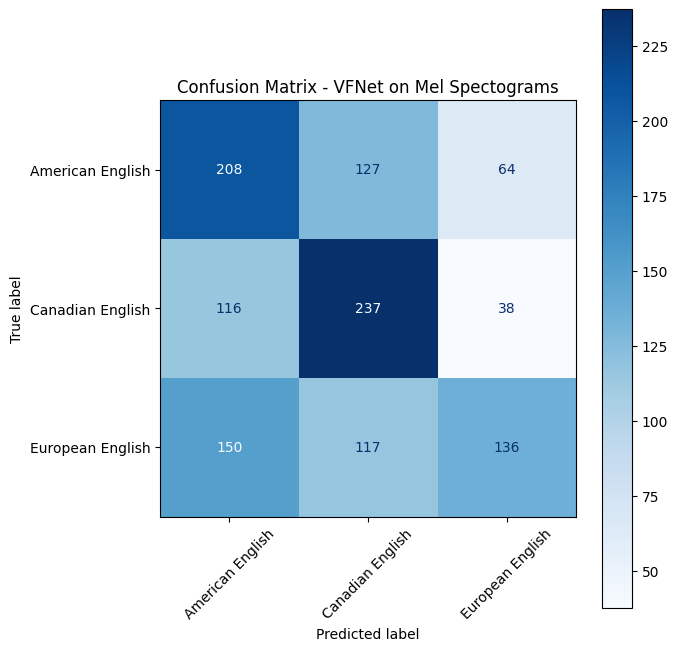

In [15]:
plt.figure(figsize=(12,5))

# accuracy plot
plt.subplot(1,2,1)
plt.plot(history_vfnet_melspec.history['accuracy'], label='Train Accuracy')
plt.plot(history_vfnet_melspec.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VFNet on Mel Spectograms Accuracy')
plt.legend()

# loss plot
plt.subplot(1,2,2)
plt.plot(history_vfnet_melspec.history['loss'], label='Train Loss')
plt.plot(history_vfnet_melspec.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VFNet on Mel Spectograms Loss')
plt.legend()

plt.tight_layout()
plt.show()

# evaluate
y_pred_vfnet_melspec = np.argmax(model_vfnet_melspec.predict(X_test_melspec), axis=1)
print(classification_report(y_test_melspec, y_pred_vfnet_melspec, target_names=le.classes_))

# confusion matrix
cm_vfnet_melspec = confusion_matrix(y_test_melspec, y_pred_vfnet_melspec)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vfnet_melspec, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - VFNet on Mel Spectograms")
plt.tight_layout()
plt.show()